# Refined Bookmark Clustering with Hierarchical Clustering

This notebook focuses on hierarchical clustering, testing LSA and cosine similarity, and improving the folder structure.

In [21]:
import json
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Helper Functions

In [22]:
def analyze_embeddings(embeddings):
    print("Embedding analysis:")
    print(f"Shape: {embeddings.shape}")
    print(f"Mean: {np.mean(embeddings)}")
    print(f"Std: {np.std(embeddings)}")
    print(f"Min: {np.min(embeddings)}")
    print(f"Max: {np.max(embeddings)}")
    
    plt.figure(figsize=(10, 5))
    plt.hist(embeddings.flatten(), bins=50)
    plt.title("Distribution of Embedding Values")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()


def preprocess_embeddings(embeddings):
    # Center the embeddings
    embeddings_centered = embeddings - np.mean(embeddings, axis=0)
    # Normalize to unit length
    norms = np.linalg.norm(embeddings_centered, axis=1, keepdims=True)
    norms[norms == 0] = 1  # Avoid division by zero
    embeddings_normalized = embeddings_centered / norms
    return embeddings_normalized

def reduce_dimensions(embeddings, n_components=50):
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced = svd.fit_transform(embeddings)
    return reduced

def print_folder_structure(item, indent=0):
    if isinstance(item, dict):
        if 'children' in item:
            # This is a folder
            name = item.get('name', 'Unnamed Folder')
            print("  " * indent + f"+ {name} ({len(item['children'])} items)")
            for child in item['children']:
                print_folder_structure(child, indent + 1)
        else:
            # This is a bookmark
            title = item.get('title', 'Untitled Bookmark')
            print("  " * indent + f"- {title} (Bookmark)")
    else:
        # This is likely a bookmark represented as a simple string or other type
        print("  " * indent + f"- {str(item)} (Unknown Item)")

def build_hierarchical_structure(Z, labels, bookmark_data):
    n = len(bookmark_data)
    clusters = [{"title": bookmark["title"], "url": bookmark["url"]} for bookmark in bookmark_data]
    
    for i, merge in enumerate(Z):
        left, right = int(merge[0]), int(merge[1])
        new_cluster = {
            "name": f"Folder {n + i}",
            "children": [clusters[left], clusters[right]]
        }
        clusters.append(new_cluster)
    
    root = clusters[-1]
    return root

## Improved Clustering Function

In [23]:
def optimize_hierarchical_clustering(embeddings, use_lsa=True):
    best_score = -1
    best_params = {}
    best_labels = None
    best_Z = None
    
    if use_lsa:
        embeddings = reduce_dimensions(embeddings)
    
    methods = ['ward', 'complete', 'average']
    metrics = ['euclidean', 'cosine']
    
    for method in tqdm(methods, desc="Trying linkage methods"):
        for metric in metrics:
            if method == 'ward' and metric != 'euclidean':
                continue
            
            print(f"Trying method: {method}, metric: {metric}")
            
            try:
                if metric == 'cosine':
                    distances = 1 - cosine_similarity(embeddings)
                    distances = np.clip(distances, 0, None)  # Ensure non-negative
                    distances_condensed = distances[np.triu_indices(distances.shape[0], k=1)]
                    Z = linkage(distances_condensed, method=method, metric='euclidean')
                else:
                    Z = linkage(embeddings, method=method, metric=metric)
                
                method_best_score = -1
                method_best_params = {}
                method_best_labels = None
                
                for t in np.arange(0.5, 3.0, 0.05):  # More granular threshold search
                    labels = fcluster(Z, t=t, criterion='distance')
                    
                    if len(np.unique(labels)) > 1:
                        score = silhouette_score(embeddings, labels, metric='cosine')
                        print(f"  Threshold: {t:.2f}, Score: {score:.4f}, Clusters: {len(np.unique(labels))}")
                        
                        if score > method_best_score + 1e-6:  # Use small epsilon for comparison
                            method_best_score = score
                            method_best_params = {'method': method, 'metric': metric, 'threshold': t}
                            method_best_labels = labels
                
                print(f"Best score for {method}, {metric}: {method_best_score:.4f}")
                
                if method_best_score > best_score + 1e-6:
                    best_score = method_best_score
                    best_params = method_best_params
                    best_labels = method_best_labels
                    best_Z = Z
            
            except Exception as e:
                print(f"Error with method {method} and metric {metric}: {str(e)}")
                continue
    
    if best_labels is not None and len(np.unique(best_labels)) == 1:
        print("Warning: All cluster labels are the same!")
    
    return best_score, best_params, best_labels, best_Z

## Load Data and Perform Clustering

Embedding analysis:
Shape: (258, 768)
Mean: 0.000832342818566706
Std: 0.543851533816558
Min: -2.152575
Max: 2.205148


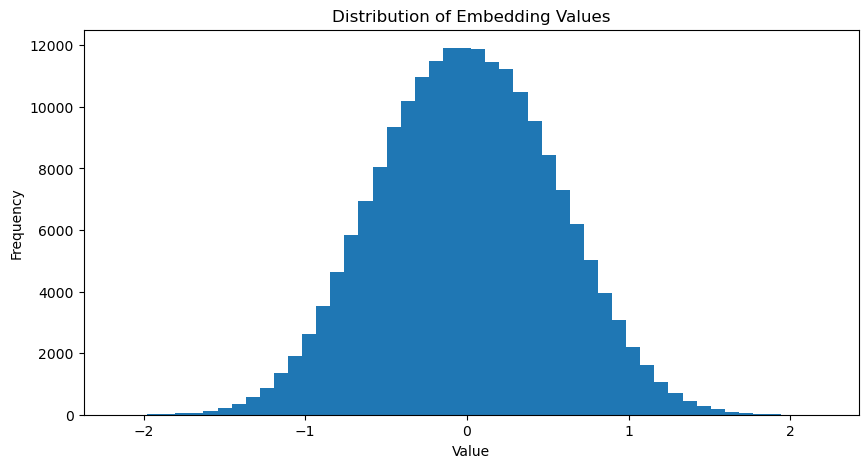


Hierarchical Clustering with LSA:


Trying linkage methods:   0%|          | 0/3 [00:00<?, ?it/s]

Trying method: ward, metric: euclidean
  Threshold: 0.50, Score: 0.0378, Clusters: 250
  Threshold: 0.55, Score: 0.0505, Clusters: 244
  Threshold: 0.60, Score: 0.0741, Clusters: 236
  Threshold: 0.65, Score: 0.0981, Clusters: 224
  Threshold: 0.70, Score: 0.1217, Clusters: 212
  Threshold: 0.75, Score: 0.1506, Clusters: 190
  Threshold: 0.80, Score: 0.1828, Clusters: 165
  Threshold: 0.85, Score: 0.2041, Clusters: 139
  Threshold: 0.90, Score: 0.2224, Clusters: 122
  Threshold: 0.95, Score: 0.2321, Clusters: 108
  Threshold: 1.00, Score: 0.2339, Clusters: 96
  Threshold: 1.05, Score: 0.2342, Clusters: 83
  Threshold: 1.10, Score: 0.2341, Clusters: 72
  Threshold: 1.15, Score: 0.2217, Clusters: 65
  Threshold: 1.20, Score: 0.2178, Clusters: 59
  Threshold: 1.25, Score: 0.2174, Clusters: 54
  Threshold: 1.30, Score: 0.2094, Clusters: 50
  Threshold: 1.35, Score: 0.2056, Clusters: 45
  Threshold: 1.40, Score: 0.1906, Clusters: 40
  Threshold: 1.45, Score: 0.1809, Clusters: 34
  Threshold

TypeError: 'numpy.int32' object is not iterable

In [24]:
# Load the embedded bookmarks
with open('embedded_bookmarks.json') as f:
    data = json.load(f)

embeddings = np.array([bookmark["embedding"] for bookmark in data])
analyze_embeddings(embeddings)

embeddings_preprocessed = preprocess_embeddings(embeddings)

print("\nHierarchical Clustering with LSA:")
lsa_score, lsa_params, lsa_labels, lsa_Z = optimize_hierarchical_clustering(embeddings_preprocessed, use_lsa=True)
print(f"Best Overall Silhouette Score (LSA): {lsa_score:.4f}")
print(f"Best Parameters (LSA): {lsa_params}")
print(f"Number of Clusters (LSA): {len(np.unique(lsa_labels))}")

print("\nHierarchical Clustering without LSA:")
no_lsa_score, no_lsa_params, no_lsa_labels, no_lsa_Z = optimize_hierarchical_clustering(embeddings_preprocessed, use_lsa=False)
print(f"Best Overall Silhouette Score (No LSA): {no_lsa_score:.4f}")
print(f"Best Parameters (No LSA): {no_lsa_params}")
print(f"Number of Clusters (No LSA): {len(np.unique(no_lsa_labels))}")

# Choose the better performing method
if lsa_score > no_lsa_score:
    print("\nLSA performed better. Using LSA results.")
    best_labels = lsa_labels
    best_Z = lsa_Z
    best_score = lsa_score
    best_params = lsa_params
else:
    print("\nNon-LSA performed better. Using non-LSA results.")
    best_labels = no_lsa_labels
    best_Z = no_lsa_Z
    best_score = no_lsa_score
    best_params = no_lsa_params

print(f"\nFinal Best Silhouette Score: {best_score:.4f}")
print(f"Final Best Parameters: {best_params}")
print(f"Final Number of Clusters: {len(np.unique(best_labels))}")

# The rest of your code for building and displaying the folder structure remains the same

## Analysis and Conclusions

In this section, you can add your observations about the clustering results, discuss the effectiveness of the different approaches (LSA vs. non-LSA, different linkage methods and metrics), and suggest potential improvements or next steps.